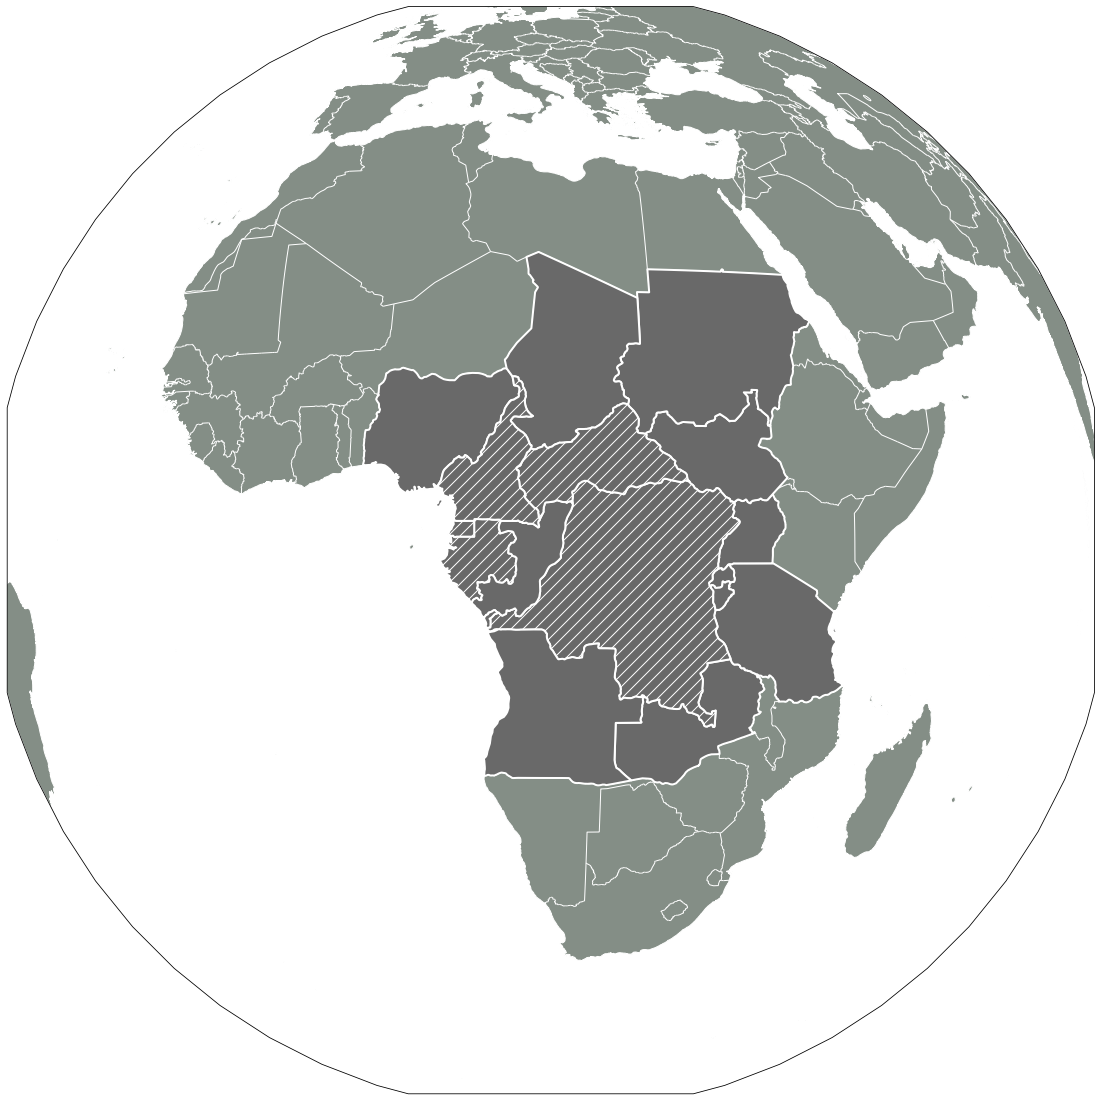

In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.collections import LineCollection
from matplotlib.patches import Rectangle,Polygon
from matplotlib.gridspec import GridSpec

typeface='Helvetica Neue'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22
mpl.rcParams['pdf.fonttype']=42

import os,glob
import numpy as np
# from Bio import SeqIO
# from collections import Counter

# import baltic as bt

import cartopy
import cartopy.crs as ccrs


# def desaturate(rgb,sat,lum=None):
#     if isinstance(rgb,str):
#         rgb=mpl.colors.hex2color(rgb) ## convert to rgb if string given
#     elif np.array(rgb).shape[-1]==4: ## if there's four values
#         rgb=rgb[:-1]
#     elif isinstance(rgb,unicode):
#         rgb=mpl.colors.hex2color(rgb) ## convert to rgb if string given

#     assert 0.0<=sat<=1.0,'Desaturation outside allowed interval'
#     assert np.array(rgb).shape[-1]==3,'Incorrect colour array shape'
#     hsv=mpl.colors.rgb_to_hsv(rgb) ## convert rgb vector to hue, saturation, value
#     hsv[1]=sat ## use provided saturation
#     if lum:
#         hsv[2]=lum ## use provided luminosity
    
#     return mpl.colors.hsv_to_rgb(hsv) ## convert back to rgb


fig = plt.subplots(figsize=(20,20),facecolor='w')

class RP(ccrs.NearsidePerspective):
    @property
    def threshold(self):
        return 1e3

# proj=ccrs.NearsidePerspective(central_longitude=17, central_latitude=-15, satellite_height=14000000, false_easting=0, false_northing=0, globe=None)

gs = GridSpec(1,1,hspace=0.01,wspace=0.0)
# ax=plt.subplot(gs[0],projection=proj)
ax=plt.subplot(gs[0],projection=RP(central_longitude=17, central_latitude=0, satellite_height=14000000))

scale='10m'
# water='#CED6D9'
water='w'
land='#848E86'

ax.add_feature(cartopy.feature.LAKES.with_scale(scale),facecolor=water)
ax.add_feature(cartopy.feature.OCEAN.with_scale(scale),facecolor=water,edgecolor=water)
ax.add_feature(cartopy.feature.LAND.with_scale(scale),facecolor=land,edgecolor='w',zorder=1)
ax.add_feature(cartopy.feature.BORDERS.with_scale(scale),edgecolor='w',lw=1,zorder=2)
# ax.gridlines(color='k',linestyle='--',alpha=0.2)

############
import cartopy.io.shapereader as shpreader
shpfilename = shpreader.natural_earth(resolution='50m', category='cultural', name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
# values = list(df[title].unique())


focal_countries=['Equatorial Guinea', 'CAR', 'Cameroon', 'Democratic Republic of the Congo', 
                            'Nigeria', 'Chad', 'Republic of the Congo', 'Gabon', 'Uganda', 
                            'Rwanda', 'Burundi', 'United Republic of Tanzania', 'Zambia', 'Angola', 'South Sudan', 'Sudan']

reporting=['Equatorial Guinea', 'CAR', 'Cameroon', 'Democratic Republic of the Congo','Gabon']

for country in countries:
#     print(country)
    name=country.attributes['ADMIN']
    if name=='Central African Republic': name='CAR'
        
#     print(name)
    if name in focal_countries:
#     if country.attributes['ADMIN'] in ['Cameroon','Mali']:
        
        
#         fc=colours[name]
        fc='dimgrey'
        hatch=''
#         print(name)
        if name in reporting:
            hatch='//'
#             print(hatch)
        
        ax.add_geometries([country.geometry], ccrs.PlateCarree(),
                          facecolor=fc,
#                           label=country.attributes[attribute],
                          edgecolor='w', hatch=hatch, linewidth=2,zorder=1000)


ax.set_xlim(-4456742.500225266, 4456742.500225266)
ax.set_ylim(-4456742.500225266, 4456742.500225266)

# plt.savefig('/Users/evogytis/Documents/manuscripts/SARS-CoV-2_kitenis/figures/SuppFig6_Africa_distribution.png',dpi=100,bbox_inches='tight')
plt.show()

In [2]:
meta={}

for line in open('/Users/evogytis/Documents/manuscripts/SARS-CoV-2_kitenis/data/gisaid/metadata_2021-07-02_11-46.tsv','r'):
    l=line.strip('\n').split('\t')
    if l[0]=='strain':
        header={x: i for i,x in enumerate(l)}
    else:
        meta[l[0]]={x: l[header[x]] for x in header}
        
        #######
        if meta[l[0]]['country']=='Tanzania':
            meta[l[0]]['country']='United Republic of Tanzania'
            
        if meta[l[0]]['country_exposure']=='Tanzania':
            meta[l[0]]['country_exposure']='United Republic of Tanzania'
            
        #######
        if meta[l[0]]['country']=='Central African Republic':
            meta[l[0]]['country']='CAR'
            
        if meta[l[0]]['country_exposure']=='Central African Republic':
            meta[l[0]]['country_exposure']='CAR'
        #######
        
        

In [3]:
import requests
import csv
from io import StringIO

pop_url='https://github.com/datasets/population/raw/master/data/population.csv'

store_yr=0

pop_size={}
for l in csv.reader(StringIO(requests.get(pop_url).text),delimiter=','):
#     print(line)
#     l=line.strip('\n').split(',')
    if l[0]=='Country Name':
        pass
#         header={x: i for i,x in enumerate(l)}
    else:
#         print(l)
        name,iso,yr,pop=l
        
        if name=='Congo, Dem. Rep.': name='Democratic Republic of the Congo'
        if name=='Central African Republic': name='CAR'
        if name=='Tanzania': name='United Republic of Tanzania'
        if name=='Congo, Rep.': name='Republic of the Congo'
        
        if name in focal_countries:
            if int(yr)>store_yr:
                pop_size[name]=int(pop)
        
        store_yr=int(yr)

In [4]:
case_url='https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

cases={}
coords={}
for l in csv.reader(StringIO(requests.get(case_url).text),delimiter=','):
#     print(line)
#     l=line.strip('\n').split(',')
    if l[0]=='Province/State':
        header={x: i for i,x in enumerate(l)}
        timeline=l[4:]
    else:
#         print(l)
#         name,iso,yr,pop=l
        name=l[header['Country/Region']]
        
        if name=='Congo (Kinshasa)': name='Democratic Republic of the Congo'
        if name=='Central African Republic': name='CAR'
        if name=='Tanzania': name='United Republic of Tanzania'
        if name=='Congo (Brazzaville)': name='Republic of the Congo'
        
        if name in focal_countries:
            cases[name]={x: int(l[header[x]]) for x in timeline}
            coords[name]=(float(l[header['Long']]),float(l[header['Lat']]))

In [5]:
# print(pop_size)

# print(list())
import baltic as bt

# get_yr=lambda d: d.split('-')[0]

# for c in focal_countries:
    
def plot_cases(ax,country,i,j):
    
    c=country
    get_yr=lambda d: d.split('-')[0]
#     print(c)
    
#     fig = plt.subplots(figsize=(20,10),facecolor='w')
    
#     gs = GridSpec(1,1,hspace=0.01,wspace=0.0)
#     ax=plt.subplot(gs[0],facecolor='none')
    
    sorted_timeline=[x for x in sorted(cases[c],key=lambda w: bt.decimalDate(w,'%m/%d/%y'))]
    
    fmt_timeline=[bt.convertDate(x,'%m/%d/%y','%Y-%m-%d') for x in sorted_timeline]
    
    
    xs=list(map(bt.decimalDate,fmt_timeline))
    ys=[cases[c][t]/pop_size[c]*100e3 for t in sorted_timeline]
    
    idx2021=fmt_timeline.index('2021-01-01')
    
    begin2020=min(xs)
    begin2021=bt.decimalDate(fmt_timeline[idx2021])
    end2021=max(xs)
    
    
#     print(timeline)
    in_country=[s for s in meta if meta[s]['country']==c or meta[s]['country_exposure']==c]
    
    if len(in_country)>0:
        
        ax2=ax.twinx()
    
        top=0
        
#         for yr in [2020,2021]:
        ##### 2020
        B1351=[s for s in in_country if meta[s]['pango_lineage']=='B.1.351' and int(get_yr(meta[s]['date']))==2020]
        B1620=[s for s in in_country if meta[s]['pango_lineage']=='B.1.620' and int(get_yr(meta[s]['date']))==2020]
        seq_in_year=[s for s in in_country if int(get_yr(meta[s]['date']))==2020]
        
        count_B1351=len(B1351)/cases[c][sorted_timeline[idx2021]]
        count_B1620=len(B1620)/cases[c][sorted_timeline[idx2021]]
        count_all=len(seq_in_year)/cases[c][sorted_timeline[idx2021]]
        
        if count_all>top:
            top=count_all
        
        ax2.add_patch(Rectangle((begin2020,0),begin2021-begin2020,count_B1351,facecolor='steelblue',edgecolor='none',zorder=1))
        ax2.add_patch(Rectangle((begin2020,count_B1351),begin2021-begin2020,count_B1620,facecolor='indianred',edgecolor='none',zorder=1))
        ax2.add_patch(Rectangle((begin2020,0),begin2021-begin2020,count_all,facecolor='lightgrey',edgecolor='none',zorder=0))
        
        label_2020=[]
        if len(B1620)>0:
#             ax2.text(np.mean([begin2020,begin2021]),count_all,'B.1.620: %d'%(len(B1620)),ha='center',va='top',size=14)
            label_2020.append('B.1.620 (%d/%d)'%(len(B1620),len(seq_in_year)))
        elif len(B1351)>0:
#             ax2.text(np.mean([begin2020,begin2021]),count_all,'B.1.351: %d'%(len(B1351)),ha='center',va='top',size=14)
            label_2020.append('B.1.351 (%d/%d)'%(len(B1351),len(seq_in_year)))
        else:
            label_2020.append('%d'%(len(seq_in_year)))
        
        
        ##### 2021
        B1351=[s for s in in_country if meta[s]['pango_lineage']=='B.1.351' and int(get_yr(meta[s]['date']))==2021]
        B1620=[s for s in in_country if meta[s]['pango_lineage']=='B.1.620' and int(get_yr(meta[s]['date']))==2021]
        seq_in_year=[s for s in in_country if int(get_yr(meta[s]['date']))==2021]
        
        count_B1351=len(B1351)/cases[c][sorted_timeline[-1]]
        count_B1620=len(B1620)/cases[c][sorted_timeline[-1]]
        count_all=len(seq_in_year)/cases[c][sorted_timeline[-1]]
        
        if count_all>top:
            top=count_all
        
        ax2.add_patch(Rectangle((begin2021,0),end2021-begin2021,count_B1351,facecolor='steelblue',edgecolor='none',zorder=1))
        ax2.add_patch(Rectangle((begin2021,count_B1351),end2021-begin2021,count_B1620,facecolor='indianred',edgecolor='none',zorder=1))
        ax2.add_patch(Rectangle((begin2021,0),end2021-begin2021,count_all,facecolor='lightgrey',edgecolor='none',zorder=0))
        
        label_2021=[]
        if len(B1620)>0:
            label_2021.append('B.1.620 (%d/%d)'%(len(B1620),len(seq_in_year)))
#             ax2.text(np.mean([begin2021,end2021]),count_all,'B.1.620: %d'%(len(B1620)),ha='center',va='top',size=14)
        elif len(B1351)>0:
#             ax2.text(np.mean([begin2021,end2021]),count_all,'B.1.351: %d'%(len(B1351)),ha='center',va='top',size=14)
            label_2021.append('B.1.351 (%d/%d)'%(len(B1351),len(seq_in_year)))
        else:
            label_2021.append('%d'%(len(seq_in_year)))
        
        if len(label_2020)>0 and len(label_2021)>0:
            ax2.text(0.01,0.99,'2020: %s\n2021: %s'%(','.join(label_2020),','.join(label_2021)),ha='left',va='top',size=18,transform=ax.transAxes,zorder=10000)
        elif len(label_2020)>0:
            ax2.text(0.01,0.99,'2020: %s'%(','.join(label_2020)),ha='left',va='top',size=18,transform=ax.transAxes,zorder=10000)
        elif len(label_2021)>0:
            ax2.text(0.01,0.99,'2021: %s'%(','.join(label_2021)),ha='left',va='top',size=18,transform=ax.transAxes,zorder=10000)
        
        
#         ax2.set_ylim(0,0.03)
        ax2.set_ylim(0,top*1.05)
        ax2.set_zorder(0)
        
        if j==5 or j==4:
            ax2.set_ylabel('proportion of sequenced cases',size=16)
            
        ax2.tick_params(labelsize=18)
    
    ax.plot(xs,ys,color='k',lw=2,zorder=10)
    ax.plot(xs,ys,color='w',lw=5,zorder=9)
    
#     ax.set_ylim(0,900)
    
    ax.set_zorder(1)
    
    calendar_timeline=['2020-%02d-01'%(m) for m in range(2,13)]
    calendar_timeline+=['2021-%02d-01'%(m) for m in range(1,8)]
    
    ax.set_xticks(list(map(bt.decimalDate,calendar_timeline)))
    
    ax.axvline(bt.decimalDate('2021-01-01'),color='k',lw=1)
    
    if i==4 or i==5:
        ax.set_xticklabels([(bt.convertDate(m,'%Y-%m-%d','%b') if '-01-' not in m else bt.convertDate(m,'%Y-%m-%d','%b\n%Y')) if (2+int(m.split('-')[1]))%3==0 else '' for m in calendar_timeline])
    else:
        ax.set_xticklabels([])
        
    ax.set_xlim(bt.decimalDate('2020-01-20'),bt.decimalDate('2021-07-01'))
    ax.grid(axis='x',ls='--')
    
    if j==0 or j==1:
        ax.set_ylabel('cumulative cases per 100k inhabitants',size=16)
    
    
    if country=='Democratic Republic of the Congo': country='DRC'
    if country=='Central African Republic': country='CAR'
    if country=='United Republic of Tanzania': country='Tanzania'
    
    ax.text(0.01,1.0,country,ha='left',va='bottom',size=20,transform=ax.transAxes)
    
    ax.tick_params(labelsize=18)
    
    
    return ax
#     plt.show()

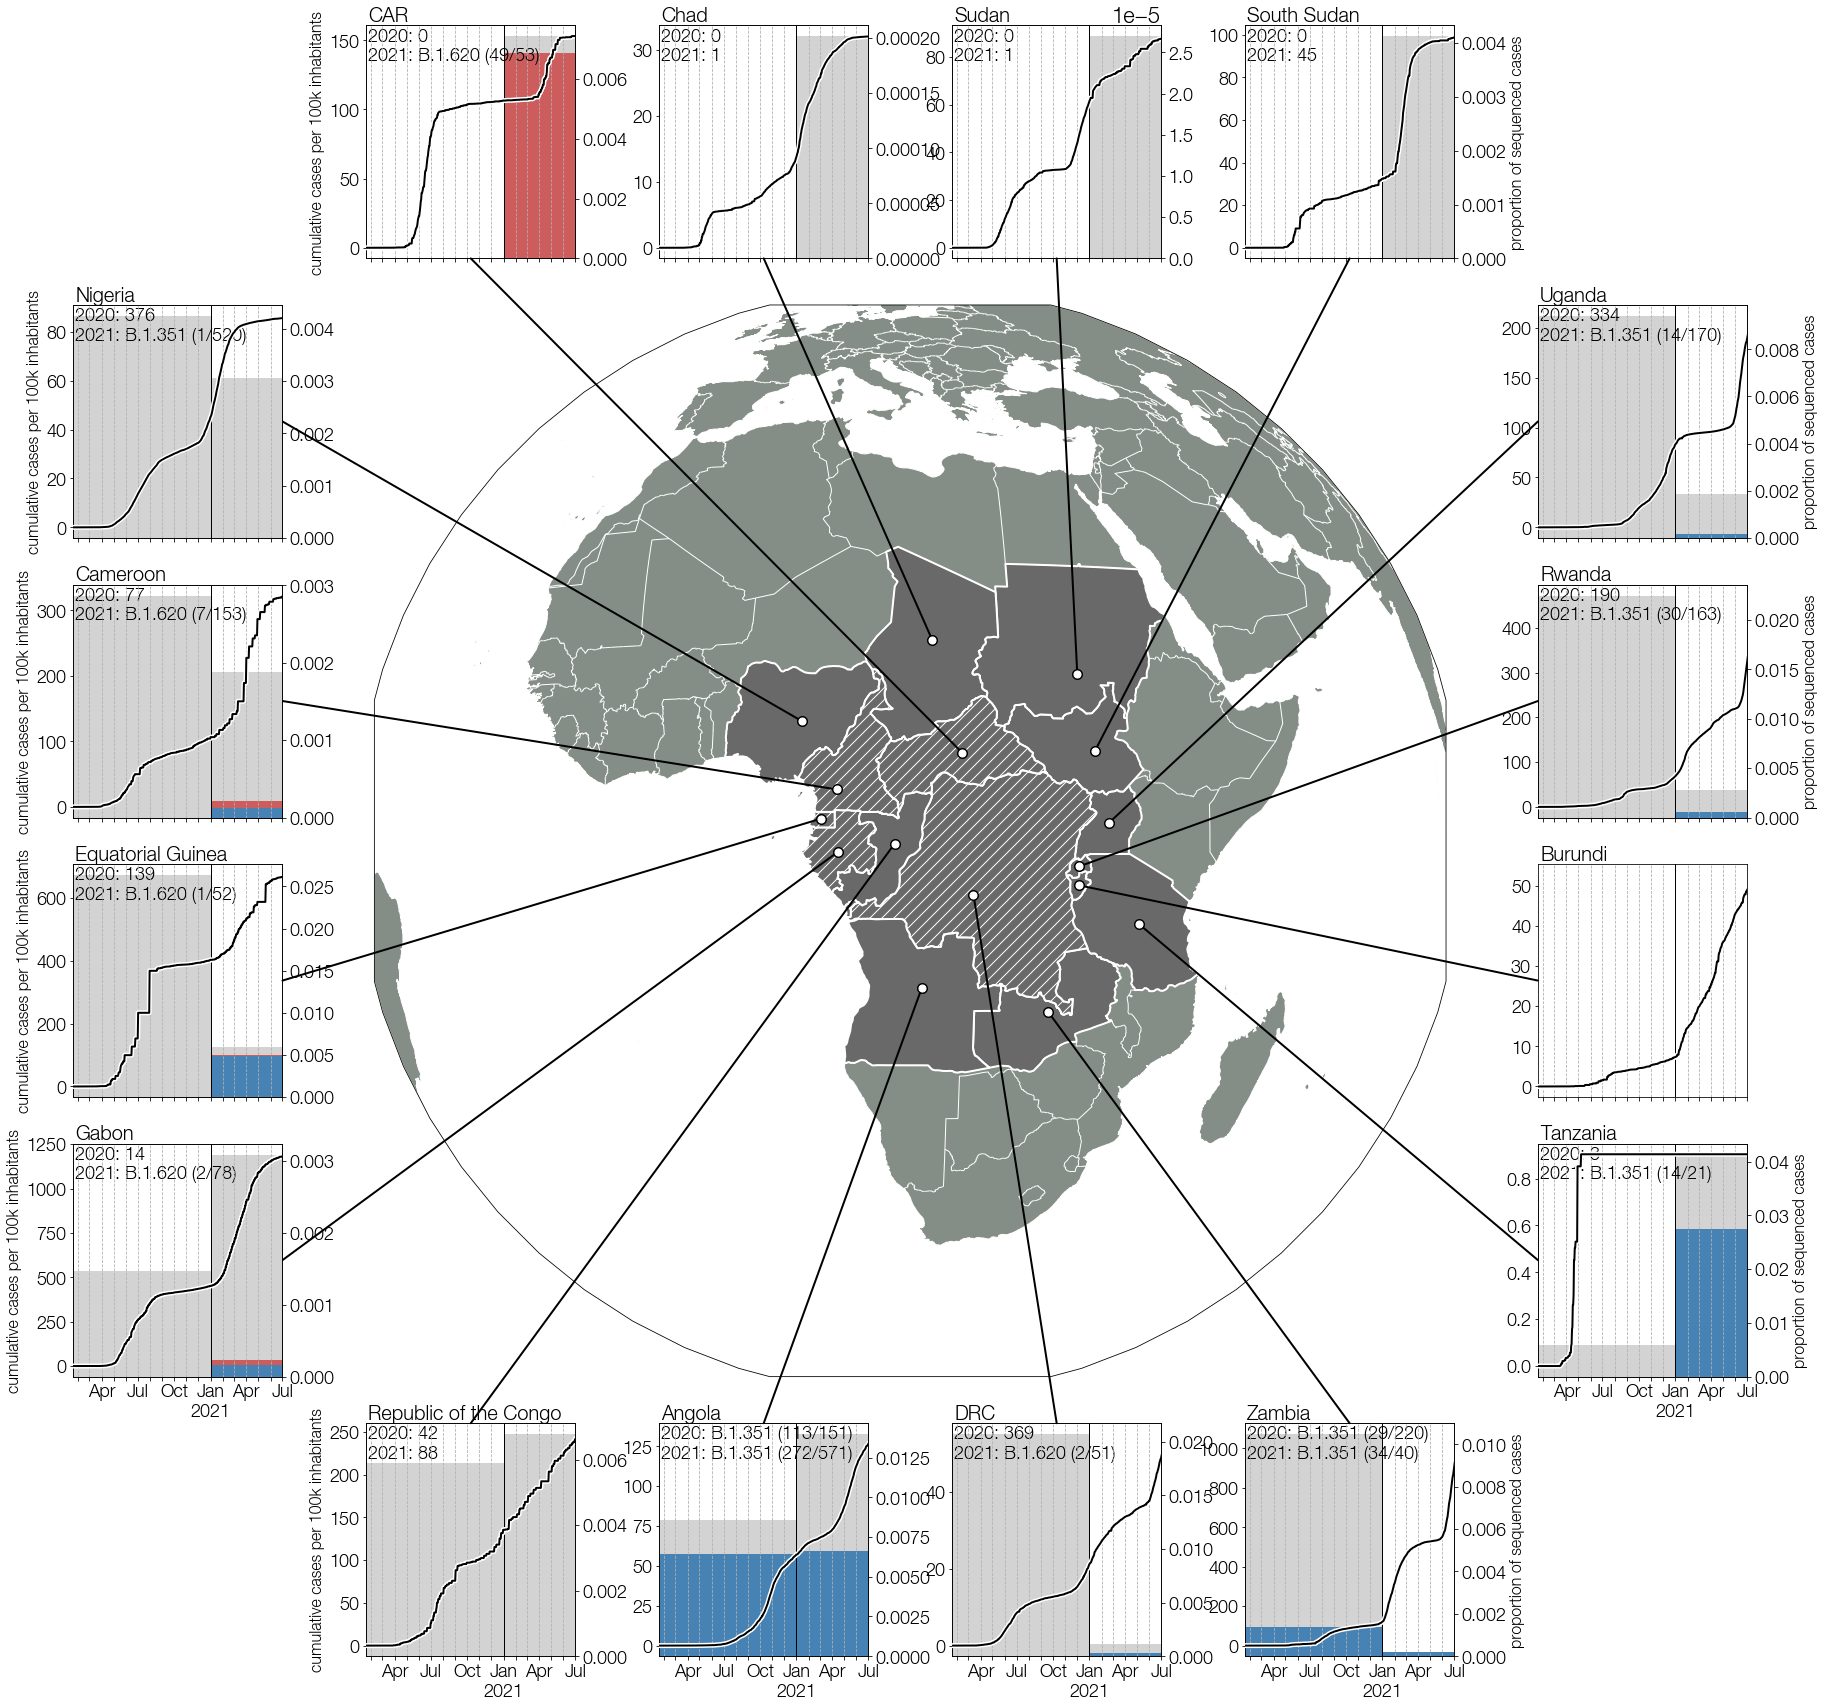

In [6]:
from matplotlib.patches import ConnectionPatch

fig = plt.subplots(figsize=(30,30),facecolor='w')

class RP(ccrs.NearsidePerspective):
    @property
    def threshold(self):
        return 1e3

# proj=ccrs.NearsidePerspective(central_longitude=17, central_latitude=-15, satellite_height=14000000, false_easting=0, false_northing=0, globe=None)

gs = GridSpec(6,6,hspace=0.2,wspace=0.4)
# ax=plt.subplot(gs[0],projection=proj)
proj=RP(central_longitude=17, central_latitude=0, satellite_height=14000000)
ax=plt.subplot(gs[1:-1,1:-1],projection=proj)


scale='10m'
# water='#CED6D9'
water='w'
land='#848E86'

ax.add_feature(cartopy.feature.LAKES.with_scale(scale),facecolor=water)
ax.add_feature(cartopy.feature.OCEAN.with_scale(scale),facecolor=water,edgecolor=water)
ax.add_feature(cartopy.feature.LAND.with_scale(scale),facecolor=land,edgecolor='w',zorder=1)
ax.add_feature(cartopy.feature.BORDERS.with_scale(scale),edgecolor='w',lw=1,zorder=2)
# ax.gridlines(color='k',linestyle='--',alpha=0.2)

############
import cartopy.io.shapereader as shpreader
shpfilename = shpreader.natural_earth(resolution='50m', category='cultural', name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()
# values = list(df[title].unique())


focal_countries=['Equatorial Guinea', 'CAR', 'Cameroon', 'Democratic Republic of the Congo', 
                            'Nigeria', 'Chad', 'Republic of the Congo', 'Gabon', 'Uganda', 
                            'Rwanda', 'Burundi', 'United Republic of Tanzania', 'Zambia', 'Angola', 'South Sudan', 'Sudan']

reporting=['Equatorial Guinea', 'CAR', 'Cameroon', 'Democratic Republic of the Congo','Gabon']

for country in countries:
#     print(country)
    name=country.attributes['ADMIN']
    if name=='Central African Republic': name='CAR'
        
#     print(name)
    if name in focal_countries:
#     if country.attributes['ADMIN'] in ['Cameroon','Mali']:
        
        
#         fc=colours[name]
        fc='dimgrey'
        hatch=''
#         print(name)
        if name in reporting:
            hatch='//'
#             print(hatch)
        
        ax.add_geometries([country.geometry], ccrs.PlateCarree(),
                          facecolor=fc,
#                           label=country.attributes[attribute],
                          edgecolor='w', hatch=hatch, linewidth=2,zorder=1)
        
#         print(coords[name])
        s=50
        ax.scatter(*coords[name],s=s,facecolor='w',transform=ccrs.PlateCarree(),zorder=8)
        ax.scatter(*coords[name],s=s*2,facecolor='k',transform=ccrs.PlateCarree(),zorder=7)
        
        
        

ax.set_xlim(-4456742.500225266, 4456742.500225266)
ax.set_ylim(-4456742.500225266, 4456742.500225266)



subplot_coordinates={'Equatorial Guinea': (3,0), 
                     'CAR': (0,1), 
                     'Cameroon': (2,0), 
                     'Democratic Republic of the Congo': (5,3), 
                     'Nigeria': (1,0), 
                     'Chad': (0,2), 
                     'Republic of the Congo': (5,1), 
                     'Gabon': (4,0), 
                     'Uganda': (1,5), 
                     'Rwanda': (2,5), 
                     'Burundi': (3,5), 
                     'United Republic of Tanzania': (4,5), 
                     'Zambia': (5,4), 
                     'Angola': (5,2), 
                     'South Sudan': (0,4), 
                     'Sudan': (0,3)}


for country in subplot_coordinates:
    i,j=subplot_coordinates[country]
    ax2=plt.subplot(gs[i,j],facecolor='none')
    
    if i==0:
        target_x=0.5
        target_y=0.0
    elif j==0:
        target_x=1.0
        target_y=0.5
    elif j==5:
        target_x=0.0
        target_y=0.5
    elif i==5:
        target_x=0.5
        target_y=1.0
    
    latT,lonT=proj.transform_point(*coords[country], ccrs.PlateCarree())
    
    con = ConnectionPatch(xyA=(target_x,target_y), 
                          coordsA=ax2.transAxes, 
                          axesA=ax2,
                          xyB=(latT,lonT), 
                          coordsB=ax.transData,
                          axesB=ax, 
                          color='k', ls='-',lw=2,zorder=3,alpha=1)

    ax.add_patch(con)
    
    plot_cases(ax2,country,i,j)

plt.savefig('/Users/evogytis/Documents/manuscripts/SARS-CoV-2_kitenis/figures/SuppFig8_AfricaCases.png',dpi=100,bbox_inches='tight')
plt.show()